## Importing packages

In [1]:
import numpy as np
import pandas as pd

# visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

# Data stratifying and splitting
from sklearn.model_selection import train_test_split,StratifiedKFold
# KFold devides the dataset into k folds. 
# Where as Stratified ensures that each fold of dataset has the same proportion of observations with a given label.

# preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import f_classif,SelectKBest
from sklearn.compose import ColumnTransformer

# class imbalance
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

# model evaluation
from imblearn.metrics import classification_report_imbalanced
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score

# models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC,SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


# performance check
import time
import warnings

warnings.filterwarnings("ignore")

# sparse to dense
from sklearn.base import TransformerMixin


class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()


# saving the model
from joblib import dump



In [2]:
# load the dataset
df=pd.read_csv(r"D:\data\clean_data_3.csv")
df.columns

Index(['type', 'is_Extrovert', 'is_Sensing', 'is_Thinking', 'is_Judging',
       'posts', 'clean_posts', 'compound_sentiment', 'pos_sentiment',
       'neg_sentiment',
       ...
       'em', 'emojis', 'colon', 'unique_words', 'word_count', 'upper_case',
       'link_count', 'ellipses_count', 'img_count', 'post_length'],
      dtype='object', length=126)

In [3]:
## Setting X and y
X= df[
    [
        "clean_posts",
        "compound_sentiment",
        "ADJ_avg",
        "ADP_avg",
        "ADV_avg",
        "CONJ_avg",
        "DET_avg",
        "NOUN_avg",
        "NUM_avg",
        "PRT_avg",
        "PRON_avg",
        "VERB_avg",
        "qm",
        "em",
        "colon",
        "emojis",
        "word_count",
        "unique_words",
        "upper_case",
        "link_count",
        "ellipses_count",
        "img_count",
    ]
]
# setting y to four target classes -> is_Extrovert, is_Sensing, is_Thinking, is_Judging
y=df.iloc[:,1:5]


In [4]:
X.shape,y.shape

((8588, 22), (8588, 4))

## Creating a list of words (other than the stop words) to be dropped to improve model performanace


In [5]:
additional_stopwords = [
    "hey",
    "hello",
    "briggs",
    "cat",
    "car",
    "mbti",
    "soup",
    "tea",
    "sport",
    "snow",
    "christmas",
]

### Setting up preprocessor for vectorization and selecting best counts and scores

In [6]:
# preprocessing steps for selecting best k columns/features from counts & scores and for vectorizing words

counts_scores = [
    "compound_sentiment",
    "ADJ_avg",
    "ADP_avg",
    "ADV_avg",
    "CONJ_avg",
    "DET_avg",
    "NOUN_avg",
    "NUM_avg",
    "PRT_avg",
    "PRON_avg",
    "VERB_avg",
    "qm",
    "em",
    "colon",
    "emojis",
    "word_count",
    "unique_words",
    "upper_case",
    "link_count",
    "ellipses_count",
    "img_count",
]
# for selecting k best features from features other than words
best_k_features=make_pipeline(MinMaxScaler(),SelectKBest(f_classif,k=10))

In [1]:
# for i in counts_scores:
#     print(df[i])

In [7]:
# setting up preprocessionf for Tf-IDF vectorizer
preprocesser_tf = ColumnTransformer(
    transformers=[
        (
            "tfidf",
            TfidfVectorizer(min_df=25,max_df=0.85,stop_words=additional_stopwords),
            "clean_posts",
        ),
        ("selectbest", best_k_features, counts_scores),
    ],
    remainder="passthrough",
)
# setting up preprocessionf for CountVectorizer vectorizer

preprocesser_ct = ColumnTransformer(
    transformers=[
        (
            "CountVectorizer",
            CountVectorizer(min_df=25, max_df=0.85, stop_words=additional_stopwords),
            "clean_posts",
        ),
        ("selectbest", best_k_features, counts_scores),
    ],
    remainder="passthrough",
)

In [8]:
# function to build the model for predicting each of 4 target classes
def build_model(model,X,target,vectorizer_name):
    for col in target.columns:
        
        print(f"\n{mbti_type[col]}")
        target=y[col]
        
        X_train,X_test,y_train,y_test=train_test_split(X,target,test_size=0.2,random_state=42,stratify=target)
        # fit the model
        model.fit(X_train,y_train)
        
        # predictions
        y_preds=model.predict(X_test)
        y_proba=model.predict_proba(X_test)[:,1]
        
        # precision score
        average_precision=average_precision_score(y_test,y_proba)
        
        #model evaluation
        print(
            f"Geometric Mean Score: {geometric_mean_score(y_test, y_preds, average='weighted'):.2f}"
        )
        print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.2f}")
        print(f"Average Precision-Recall Score: {average_precision:.2f}")
        print(classification_report_imbalanced(y_test, y_preds))

# setting up the personality dictionary for printing scores for each class
mbti_type = {
    "is_Extrovert": "Extrovert vs Introvert",
    "is_Sensing": "Sensing vs Intuition",
    "is_Thinking": "Thinking vs Feeling",
    "is_Judging": "Judging vs Perceiving",
}

## TF-IDF Logistic Regression

In [9]:
tfidf_logistic_regression=imb_make_pipeline(
    preprocesser_tf,RandomUnderSampler(),LogisticRegressionCV()
)
build_model(tfidf_logistic_regression,X,y,"tfidf")


Extrovert vs Introvert
Geometric Mean Score: 0.68
ROC-AUC Score: 0.75
Average Precision-Recall Score: 0.45
                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.67      0.69      0.76      0.68      0.47      1322
          1       0.39      0.69      0.67      0.50      0.68      0.47       396

avg / total       0.77      0.68      0.69      0.70      0.68      0.47      1718


Sensing vs Intuition
Geometric Mean Score: 0.72
ROC-AUC Score: 0.79
Average Precision-Recall Score: 0.39
                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.67      0.77      0.78      0.72      0.51      1481
          1       0.27      0.77      0.67      0.40      0.72      0.52       237

avg / total       0.85      0.68      0.76      0.73      0.72      0.51      1718


Thinking vs Feeling
Geometric Mean Score: 0.79
ROC-AUC Score: 0.87
Average Precision-Recall Score: 0.84
           

In [10]:
tfidf_logistic_oversampling=imb_make_pipeline(preprocesser_tf,RandomOverSampler(sampling_strategy='minority'),LogisticRegressionCV())
build_model(tfidf_logistic_oversampling,X,y,"tfidf")


Extrovert vs Introvert
Geometric Mean Score: 0.63
ROC-AUC Score: 0.72
Average Precision-Recall Score: 0.44
                   pre       rec       spe        f1       geo       iba       sup

          0       0.83      0.83      0.45      0.83      0.61      0.39      1322
          1       0.44      0.45      0.83      0.44      0.61      0.36       396

avg / total       0.74      0.74      0.54      0.74      0.61      0.38      1718


Sensing vs Intuition
Geometric Mean Score: 0.60
ROC-AUC Score: 0.75
Average Precision-Recall Score: 0.40
                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      0.92      0.35      0.91      0.56      0.34      1481
          1       0.42      0.35      0.92      0.38      0.56      0.30       237

avg / total       0.83      0.84      0.43      0.84      0.56      0.33      1718


Thinking vs Feeling
Geometric Mean Score: 0.79
ROC-AUC Score: 0.87
Average Precision-Recall Score: 0.84
           

In [11]:
tfidf_logistic_oversampling=imb_make_pipeline(preprocesser_tf,RandomOverSampler(sampling_strategy=0.85),LogisticRegressionCV())
build_model(tfidf_logistic_oversampling,X,y,"tfidf")


Extrovert vs Introvert
Geometric Mean Score: 0.64
ROC-AUC Score: 0.74
Average Precision-Recall Score: 0.46
                   pre       rec       spe        f1       geo       iba       sup

          0       0.84      0.84      0.45      0.84      0.61      0.39      1322
          1       0.45      0.45      0.84      0.45      0.61      0.36       396

avg / total       0.75      0.75      0.54      0.75      0.61      0.39      1718


Sensing vs Intuition
Geometric Mean Score: 0.60
ROC-AUC Score: 0.75
Average Precision-Recall Score: 0.40
                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      0.92      0.35      0.91      0.57      0.34      1481
          1       0.42      0.35      0.92      0.38      0.57      0.30       237

avg / total       0.83      0.84      0.43      0.84      0.57      0.34      1718


Thinking vs Feeling
Geometric Mean Score: 0.79
ROC-AUC Score: 0.87
Average Precision-Recall Score: 0.84
           

## Count Vectorized Logistic Regression


In [12]:
ct_logistic_regression = imb_make_pipeline(
    preprocesser_ct, RandomUnderSampler(), LogisticRegressionCV()
)
build_model(ct_logistic_regression, X, y, "CountVectorizer")


Extrovert vs Introvert
Geometric Mean Score: 0.65
ROC-AUC Score: 0.71
Average Precision-Recall Score: 0.39
                   pre       rec       spe        f1       geo       iba       sup

          0       0.86      0.68      0.62      0.76      0.65      0.42      1322
          1       0.37      0.62      0.68      0.46      0.65      0.42       396

avg / total       0.74      0.66      0.63      0.69      0.65      0.42      1718


Sensing vs Intuition
Geometric Mean Score: 0.71
ROC-AUC Score: 0.77
Average Precision-Recall Score: 0.35
                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.66      0.76      0.78      0.71      0.49      1481
          1       0.26      0.76      0.66      0.39      0.71      0.50       237

avg / total       0.85      0.67      0.75      0.72      0.71      0.50      1718


Thinking vs Feeling
Geometric Mean Score: 0.79
ROC-AUC Score: 0.86
Average Precision-Recall Score: 0.82
           

In [13]:
# Count Vectorized Logistic Regression-RandomOverSampler()
ct_logistic_regression = imb_make_pipeline(
    preprocesser_ct, RandomOverSampler(sampling_strategy=0.85), LogisticRegressionCV()
)
build_model(ct_logistic_regression, X, y, "CountVectorizer")


Extrovert vs Introvert
Geometric Mean Score: 0.61
ROC-AUC Score: 0.70
Average Precision-Recall Score: 0.40
                   pre       rec       spe        f1       geo       iba       sup

          0       0.83      0.82      0.43      0.82      0.59      0.36      1322
          1       0.41      0.43      0.82      0.42      0.59      0.34       396

avg / total       0.73      0.73      0.52      0.73      0.59      0.36      1718


Sensing vs Intuition
Geometric Mean Score: 0.60
ROC-AUC Score: 0.73
Average Precision-Recall Score: 0.36
                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      0.90      0.37      0.90      0.57      0.35      1481
          1       0.36      0.37      0.90      0.36      0.57      0.31       237

avg / total       0.82      0.82      0.44      0.82      0.57      0.34      1718


Thinking vs Feeling
Geometric Mean Score: 0.77
ROC-AUC Score: 0.86
Average Precision-Recall Score: 0.82
           

In [14]:
# Count Vectorized Logistic Regression-SMOTE()
ct_logistic_regression = imb_make_pipeline(
    preprocesser_ct, SMOTE(sampling_strategy=0.85), LogisticRegressionCV()
)
build_model(ct_logistic_regression, X, y, "CountVectorizer")


Extrovert vs Introvert
Geometric Mean Score: 0.61
ROC-AUC Score: 0.69
Average Precision-Recall Score: 0.40
                   pre       rec       spe        f1       geo       iba       sup

          0       0.82      0.82      0.41      0.82      0.58      0.35      1322
          1       0.40      0.41      0.82      0.41      0.58      0.32       396

avg / total       0.73      0.72      0.51      0.73      0.58      0.34      1718


Sensing vs Intuition
Geometric Mean Score: 0.61
ROC-AUC Score: 0.72
Average Precision-Recall Score: 0.35
                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      0.91      0.37      0.90      0.58      0.35      1481
          1       0.39      0.37      0.91      0.38      0.58      0.32       237

avg / total       0.83      0.83      0.44      0.83      0.58      0.35      1718


Thinking vs Feeling
Geometric Mean Score: 0.77
ROC-AUC Score: 0.86
Average Precision-Recall Score: 0.82
           

## TF-IDF Logistic Lasso


In [15]:
tfidf_logistic_regression_lasso = imb_make_pipeline(
    preprocesser_tf, RandomUnderSampler(), LogisticRegressionCV(penalty='l1', solver='saga' )
)
build_model(tfidf_logistic_regression_lasso, X, y, "tfidf")


Extrovert vs Introvert
Geometric Mean Score: 0.66
ROC-AUC Score: 0.72
Average Precision-Recall Score: 0.42
                   pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.66      0.66      0.75      0.66      0.43      1322
          1       0.37      0.66      0.66      0.47      0.66      0.43       396

avg / total       0.75      0.66      0.66      0.68      0.66      0.43      1718


Sensing vs Intuition
Geometric Mean Score: 0.70
ROC-AUC Score: 0.78
Average Precision-Recall Score: 0.37
                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.64      0.76      0.77      0.70      0.48      1481
          1       0.25      0.76      0.64      0.38      0.70      0.49       237

avg / total       0.85      0.66      0.74      0.71      0.70      0.48      1718


Thinking vs Feeling
Geometric Mean Score: 0.76
ROC-AUC Score: 0.85
Average Precision-Recall Score: 0.81
           

## Count Vectorized Logistic Lasso

In [16]:
ct_logistic_regression_lasso = imb_make_pipeline(
    preprocesser_ct, RandomUnderSampler(), LogisticRegressionCV(penalty='l1', solver='saga' )
)
build_model(ct_logistic_regression_lasso, X, y, "CountVectorizer")


Extrovert vs Introvert
Geometric Mean Score: 0.64
ROC-AUC Score: 0.70
Average Precision-Recall Score: 0.39
                   pre       rec       spe        f1       geo       iba       sup

          0       0.86      0.66      0.63      0.75      0.64      0.42      1322
          1       0.36      0.63      0.66      0.46      0.64      0.41       396

avg / total       0.74      0.65      0.64      0.68      0.64      0.42      1718


Sensing vs Intuition
Geometric Mean Score: 0.66
ROC-AUC Score: 0.72
Average Precision-Recall Score: 0.28
                   pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.64      0.69      0.76      0.66      0.44      1481
          1       0.23      0.69      0.64      0.35      0.66      0.44       237

avg / total       0.83      0.65      0.68      0.70      0.66      0.44      1718


Thinking vs Feeling
Geometric Mean Score: 0.76
ROC-AUC Score: 0.84
Average Precision-Recall Score: 0.80
           

In [17]:
# TF-IDF Logistic Ridge

tfidf_logistic_regression_ridge = imb_make_pipeline(
    preprocesser_tf, RandomUnderSampler(), LogisticRegressionCV(penalty='l2', solver='saga' )
)
build_model(tfidf_logistic_regression_ridge, X, y, "tfidf")


Extrovert vs Introvert
Geometric Mean Score: 0.67
ROC-AUC Score: 0.74
Average Precision-Recall Score: 0.46
                   pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.69      0.65      0.77      0.67      0.45      1322
          1       0.39      0.65      0.69      0.49      0.67      0.45       396

avg / total       0.76      0.68      0.66      0.71      0.67      0.45      1718


Sensing vs Intuition
Geometric Mean Score: 0.70
ROC-AUC Score: 0.78
Average Precision-Recall Score: 0.40
                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.69      0.71      0.80      0.70      0.49      1481
          1       0.27      0.71      0.69      0.39      0.70      0.49       237

avg / total       0.84      0.69      0.71      0.74      0.70      0.49      1718


Thinking vs Feeling
Geometric Mean Score: 0.79
ROC-AUC Score: 0.87
Average Precision-Recall Score: 0.84
           

In [18]:
# Count Vectorized Logistic Ridge

ct_logistic_regression_ridge = imb_make_pipeline(
    preprocesser_ct, RandomUnderSampler(), LogisticRegressionCV(penalty='l2', solver='saga' )
)
build_model(ct_logistic_regression_ridge, X, y, "CountVectorizer")


Extrovert vs Introvert
Geometric Mean Score: 0.64
ROC-AUC Score: 0.71
Average Precision-Recall Score: 0.39
                   pre       rec       spe        f1       geo       iba       sup

          0       0.85      0.68      0.60      0.76      0.64      0.42      1322
          1       0.36      0.60      0.68      0.45      0.64      0.41       396

avg / total       0.74      0.67      0.62      0.69      0.64      0.41      1718


Sensing vs Intuition
Geometric Mean Score: 0.71
ROC-AUC Score: 0.77
Average Precision-Recall Score: 0.35
                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.68      0.75      0.79      0.71      0.51      1481
          1       0.27      0.75      0.68      0.40      0.71      0.51       237

avg / total       0.85      0.69      0.74      0.74      0.71      0.51      1718


Thinking vs Feeling
Geometric Mean Score: 0.77
ROC-AUC Score: 0.85
Average Precision-Recall Score: 0.82
           

In [19]:
# TF-IDF Support Vector Classifier


tfidf_svc = imb_make_pipeline(
    preprocesser_tf, RandomUnderSampler(), DenseTransformer(), SVC(kernel='linear',probability=True)
)
build_model(tfidf_svc, X, y, "tfidf")


Extrovert vs Introvert
Geometric Mean Score: 0.67
ROC-AUC Score: 0.74
Average Precision-Recall Score: 0.46
                   pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.66      0.68      0.75      0.67      0.45      1322
          1       0.37      0.68      0.66      0.48      0.67      0.45       396

avg / total       0.76      0.66      0.68      0.69      0.67      0.45      1718


Sensing vs Intuition
Geometric Mean Score: 0.72
ROC-AUC Score: 0.79
Average Precision-Recall Score: 0.40
                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.67      0.78      0.78      0.72      0.51      1481
          1       0.27      0.78      0.67      0.40      0.72      0.53       237

avg / total       0.86      0.68      0.76      0.73      0.72      0.51      1718


Thinking vs Feeling
Geometric Mean Score: 0.78
ROC-AUC Score: 0.86
Average Precision-Recall Score: 0.84
           

In [20]:
# Count Vectorized Support Vector Classifier

ct_svc = imb_make_pipeline(
    preprocesser_ct, DenseTransformer(), RandomUnderSampler(), SVC(kernel='linear',probability=True)
)
build_model(ct_svc, X, y, "CountVectorizer")



Extrovert vs Introvert
Geometric Mean Score: 0.62
ROC-AUC Score: 0.67
Average Precision-Recall Score: 0.35
                   pre       rec       spe        f1       geo       iba       sup

          0       0.85      0.60      0.64      0.70      0.62      0.38      1322
          1       0.32      0.64      0.60      0.43      0.62      0.38       396

avg / total       0.73      0.61      0.63      0.64      0.62      0.38      1718


Sensing vs Intuition
Geometric Mean Score: 0.65
ROC-AUC Score: 0.72
Average Precision-Recall Score: 0.35
                   pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.62      0.68      0.74      0.65      0.42      1481
          1       0.22      0.68      0.62      0.34      0.65      0.43       237

avg / total       0.83      0.63      0.67      0.69      0.65      0.42      1718


Thinking vs Feeling
Geometric Mean Score: 0.73
ROC-AUC Score: 0.80
Average Precision-Recall Score: 0.75
           

In [21]:
# TF-IDF Naive Bayes


tfidf_nb = imb_make_pipeline(
    preprocesser_tf, DenseTransformer(), RandomUnderSampler(), MultinomialNB(),
)
build_model(tfidf_nb, X, y, "tfidf")



Extrovert vs Introvert
Geometric Mean Score: 0.71
ROC-AUC Score: 0.77
Average Precision-Recall Score: 0.46
                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      0.61      0.80      0.73      0.70      0.48      1322
          1       0.38      0.80      0.61      0.52      0.70      0.50       396

avg / total       0.79      0.66      0.76      0.68      0.70      0.49      1718


Sensing vs Intuition
Geometric Mean Score: 0.70
ROC-AUC Score: 0.80
Average Precision-Recall Score: 0.43
                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.66      0.75      0.77      0.70      0.49      1481
          1       0.26      0.75      0.66      0.39      0.70      0.50       237

avg / total       0.85      0.67      0.74      0.72      0.70      0.49      1718


Thinking vs Feeling
Geometric Mean Score: 0.76
ROC-AUC Score: 0.85
Average Precision-Recall Score: 0.80
           

In [22]:
# Count Vectorized Navie Bayes

ct_nb = imb_make_pipeline(
    preprocesser_ct, DenseTransformer(), RandomUnderSampler(), MultinomialNB()
)
build_model(ct_nb, X, y, "CountVectorizer")


Extrovert vs Introvert
Geometric Mean Score: 0.70
ROC-AUC Score: 0.75
Average Precision-Recall Score: 0.42
                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.68      0.71      0.77      0.70      0.48      1322
          1       0.40      0.71      0.68      0.51      0.70      0.49       396

avg / total       0.77      0.69      0.70      0.71      0.70      0.48      1718


Sensing vs Intuition
Geometric Mean Score: 0.73
ROC-AUC Score: 0.80
Average Precision-Recall Score: 0.41
                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.71      0.75      0.81      0.73      0.53      1481
          1       0.29      0.75      0.71      0.42      0.73      0.53       237

avg / total       0.86      0.71      0.74      0.76      0.73      0.53      1718


Thinking vs Feeling
Geometric Mean Score: 0.77
ROC-AUC Score: 0.85
Average Precision-Recall Score: 0.79
           

In [23]:
# TF-IDF Random Forest


tfidf_rf = imb_make_pipeline(
    preprocesser_tf, DenseTransformer(), RandomUnderSampler(), RandomForestClassifier(n_estimators=100,max_depth=10),
)
build_model(tfidf_rf, X, y, "tfidf")



Extrovert vs Introvert
Geometric Mean Score: 0.62
ROC-AUC Score: 0.66
Average Precision-Recall Score: 0.35
                   pre       rec       spe        f1       geo       iba       sup

          0       0.84      0.63      0.61      0.72      0.62      0.38      1322
          1       0.33      0.61      0.63      0.43      0.62      0.38       396

avg / total       0.72      0.62      0.61      0.65      0.62      0.38      1718


Sensing vs Intuition
Geometric Mean Score: 0.63
ROC-AUC Score: 0.70
Average Precision-Recall Score: 0.27
                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      0.62      0.63      0.74      0.63      0.39      1481
          1       0.21      0.63      0.62      0.32      0.63      0.39       237

avg / total       0.82      0.62      0.63      0.68      0.63      0.39      1718


Thinking vs Feeling
Geometric Mean Score: 0.74
ROC-AUC Score: 0.81
Average Precision-Recall Score: 0.76
           

In [24]:
# Count Vectorized Random Forest

ct_rf = imb_make_pipeline(
    preprocesser_ct, DenseTransformer(), RandomUnderSampler(), RandomForestClassifier(n_estimators=100,max_depth=10)
)
build_model(ct_rf, X, y, "CountVectorizer")


Extrovert vs Introvert
Geometric Mean Score: 0.67
ROC-AUC Score: 0.71
Average Precision-Recall Score: 0.41
                   pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.66      0.68      0.75      0.67      0.45      1322
          1       0.37      0.68      0.66      0.48      0.67      0.45       396

avg / total       0.76      0.66      0.67      0.69      0.67      0.45      1718


Sensing vs Intuition
Geometric Mean Score: 0.65
ROC-AUC Score: 0.71
Average Precision-Recall Score: 0.29
                   pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.62      0.68      0.74      0.65      0.42      1481
          1       0.22      0.68      0.62      0.34      0.65      0.43       237

avg / total       0.83      0.63      0.68      0.69      0.65      0.42      1718


Thinking vs Feeling
Geometric Mean Score: 0.74
ROC-AUC Score: 0.81
Average Precision-Recall Score: 0.75
           

### TF-IDF XGB Classifier

In [25]:
params = {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 
          'n_estimators': 200, 'nthread': 4, 'subsample': 0.7}

tfidf_xgboost=imb_make_pipeline(
    preprocesser_tf,RandomUnderSampler(),xgb.XGBClassifier(random_state=10, **params)
)
build_model(tfidf_xgboost,X,y,"tfidf")


Extrovert vs Introvert
Geometric Mean Score: 0.64
ROC-AUC Score: 0.71
Average Precision-Recall Score: 0.44
                   pre       rec       spe        f1       geo       iba       sup

          0       0.86      0.64      0.64      0.73      0.64      0.41      1322
          1       0.35      0.64      0.64      0.45      0.64      0.41       396

avg / total       0.74      0.64      0.64      0.67      0.64      0.41      1718


Sensing vs Intuition
Geometric Mean Score: 0.65
ROC-AUC Score: 0.70
Average Precision-Recall Score: 0.27
                   pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.60      0.70      0.73      0.65      0.42      1481
          1       0.22      0.70      0.60      0.34      0.65      0.43       237

avg / total       0.83      0.62      0.69      0.68      0.65      0.42      1718


Thinking vs Feeling
Geometric Mean Score: 0.74
ROC-AUC Score: 0.82
Average Precision-Recall Score: 0.78
           

### Count Vectorizer XGB Classifier

In [26]:
ct_rf = imb_make_pipeline(
    preprocesser_ct, RandomOverSampler(), xgb.XGBClassifier(random_state=10, **params)
)
build_model(ct_rf, X, y, "CountVectorizer")


Extrovert vs Introvert
Geometric Mean Score: 0.62
ROC-AUC Score: 0.72
Average Precision-Recall Score: 0.42
                   pre       rec       spe        f1       geo       iba       sup

          0       0.83      0.82      0.44      0.83      0.60      0.37      1322
          1       0.42      0.44      0.82      0.43      0.60      0.35       396

avg / total       0.74      0.73      0.53      0.73      0.60      0.37      1718


Sensing vs Intuition
Geometric Mean Score: 0.61
ROC-AUC Score: 0.73
Average Precision-Recall Score: 0.32
                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      0.83      0.42      0.86      0.59      0.36      1481
          1       0.28      0.42      0.83      0.34      0.59      0.34       237

avg / total       0.81      0.77      0.48      0.79      0.59      0.36      1718


Thinking vs Feeling
Geometric Mean Score: 0.74
ROC-AUC Score: 0.82
Average Precision-Recall Score: 0.78
           


Extrovert vs Introvert
                  coef
word                  
fun           4.352692
bored         3.404630
guy           3.187111
eye          -2.757502
government   -2.555718
challenge     2.475251
mind         -2.418422
family       -2.403614
dated         2.310616
business      2.272085
let           2.270742
world        -2.241766
nature       -2.235621
friend        2.179792
feel         -2.168949
dry          -2.131903
inferior     -2.128075
debate        2.113874
intelligence  2.089631
sister       -2.087868
show          2.084912

Sensing vs Intuition
               coef
word               
type       3.858532
world     -3.101379
rant       3.061303
idea      -2.830742
stuff      2.595306
pretty     2.400461
rave       2.348625
human     -2.283354
evil      -2.213327
brain     -2.117740
alot       2.042312
affect     2.011054
feel      -1.978849
usually    1.961954
intuition -1.883963
anime     -1.869288
help       1.851122
yet       -1.845522
everyone  -1.784772
sound

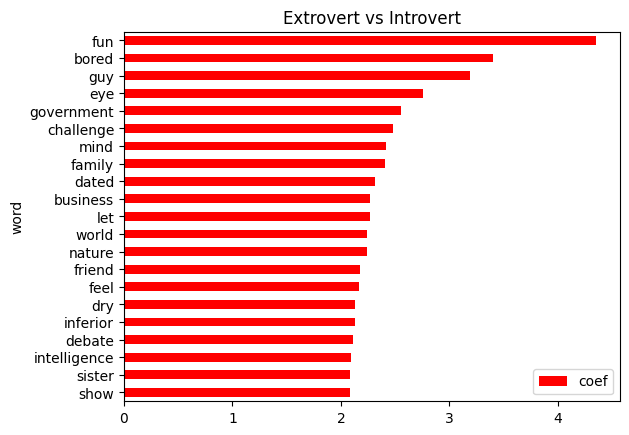

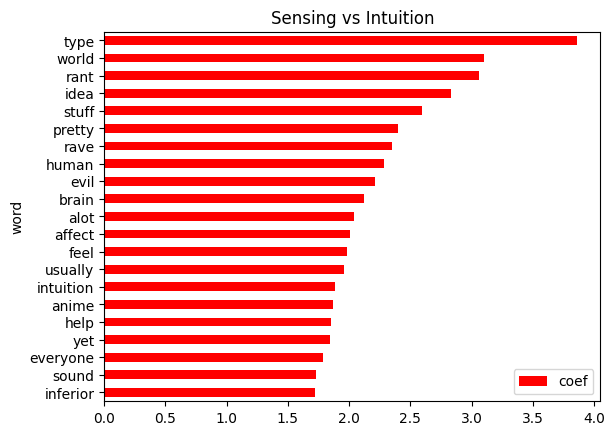

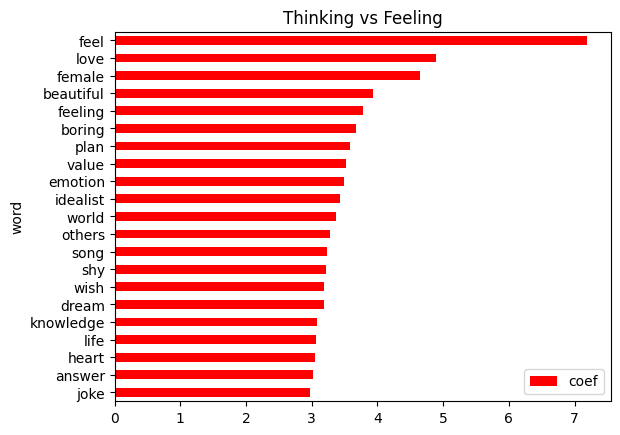

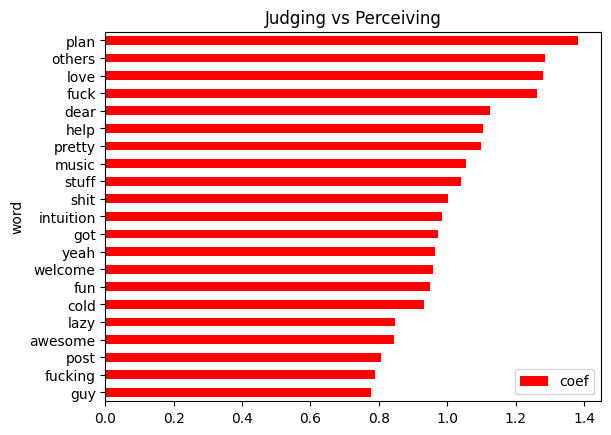

In [27]:
for col in y.columns:
    print(f"\n{mbti_type[col]}")
    target=y[col]
    tfidf_logistic_regression=imb_make_pipeline(preprocesser_tf,RandomUnderSampler(),LogisticRegressionCV())
    
    tfidf_logistic_regression.fit(X,target)
    
    # feature importance
    coef=tfidf_logistic_regression[-1].coef_[0]
    word=tfidf_logistic_regression[0].named_transformers_['tfidf'].get_feature_names()
    word_list=list(zip(word,coef))
    result=pd.DataFrame(word_list,columns=['word','coef']).set_index('word')
    result=result.reindex(result.coef.abs().sort_values(ascending=False).index)[0:21]
    print(result)
    
    # plotting feature importance
    result['coef']=result['coef'].apply(lambda x:abs(x))
    result.sort_values('coef',inplace=True)
    result.plot(kind='barh',color='r',title=mbti_type[col])
    
    # save the model
    dump(tfidf_logistic_regression,f"clf_{col}.joblib")